# Store Customer Segmentation

### Library and Data Import

In [1]:
# Library Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from datetime import datetime

In [2]:
df = pd.read_csv('Dataset\customer_segmentation.csv', sep = ';')

In [3]:
df.head()

,customerid,age,income,total_amount,total_transaction,recency
0,1,55,5.12,623300,17,227
1,10,34,4.00,478000,14,204
2,100,45,6.71,272400,8,206
3,101,61,54.20,439600,14,286
4,102,39,6.44,423300,15,217


### Data Overview

Before we do the data preparation, we will first perform a data overview and check the correlation between the features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         447 non-null    int64  
 1   age                447 non-null    int64  
 2   income             447 non-null    float64
 3   total_amount       447 non-null    int64  
 4   total_transaction  447 non-null    int64  
 5   recency            447 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 21.1 KB


There are 447 records of data, and 6 features, and there is no mising value in the dataset.

In [5]:
df.duplicated().sum()

0

and there is no duplicated data in the dataset.

**Checking the Correlation**

Text(0.5, 1.0, 'Correlation plot between numerical features')

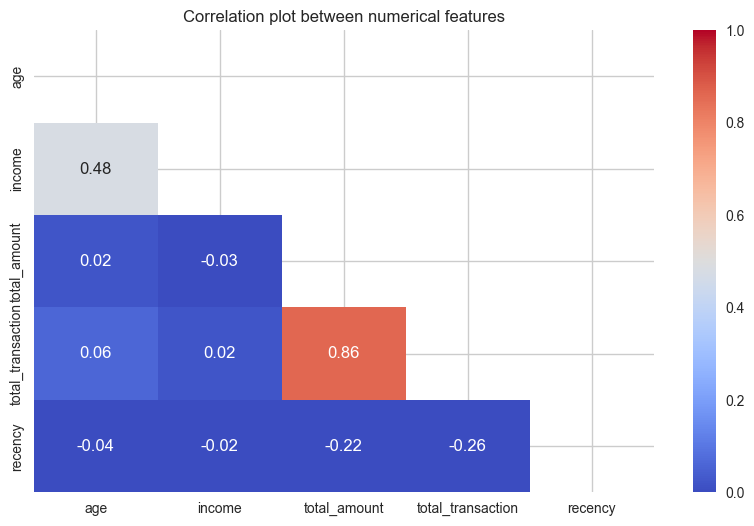

In [6]:
import numpy as np
nums = df.drop('customerid', axis = 1).columns
plt.figure(figsize=(10, 6))
mask = np.triu(np.ones_like(df[nums].corr()))
dataplot = sns.heatmap(df[nums].corr().round(2), cmap="coolwarm", annot=True, mask=mask, vmin=0, vmax=1)
plt.title('Correlation plot between numerical features')


"Total_transaction" and "Total_amount" are highly correlated, suggesting that it's better to avoid using both features simultaneously to prevent redundancy in our analysis.

**Checking the distribution of each features**

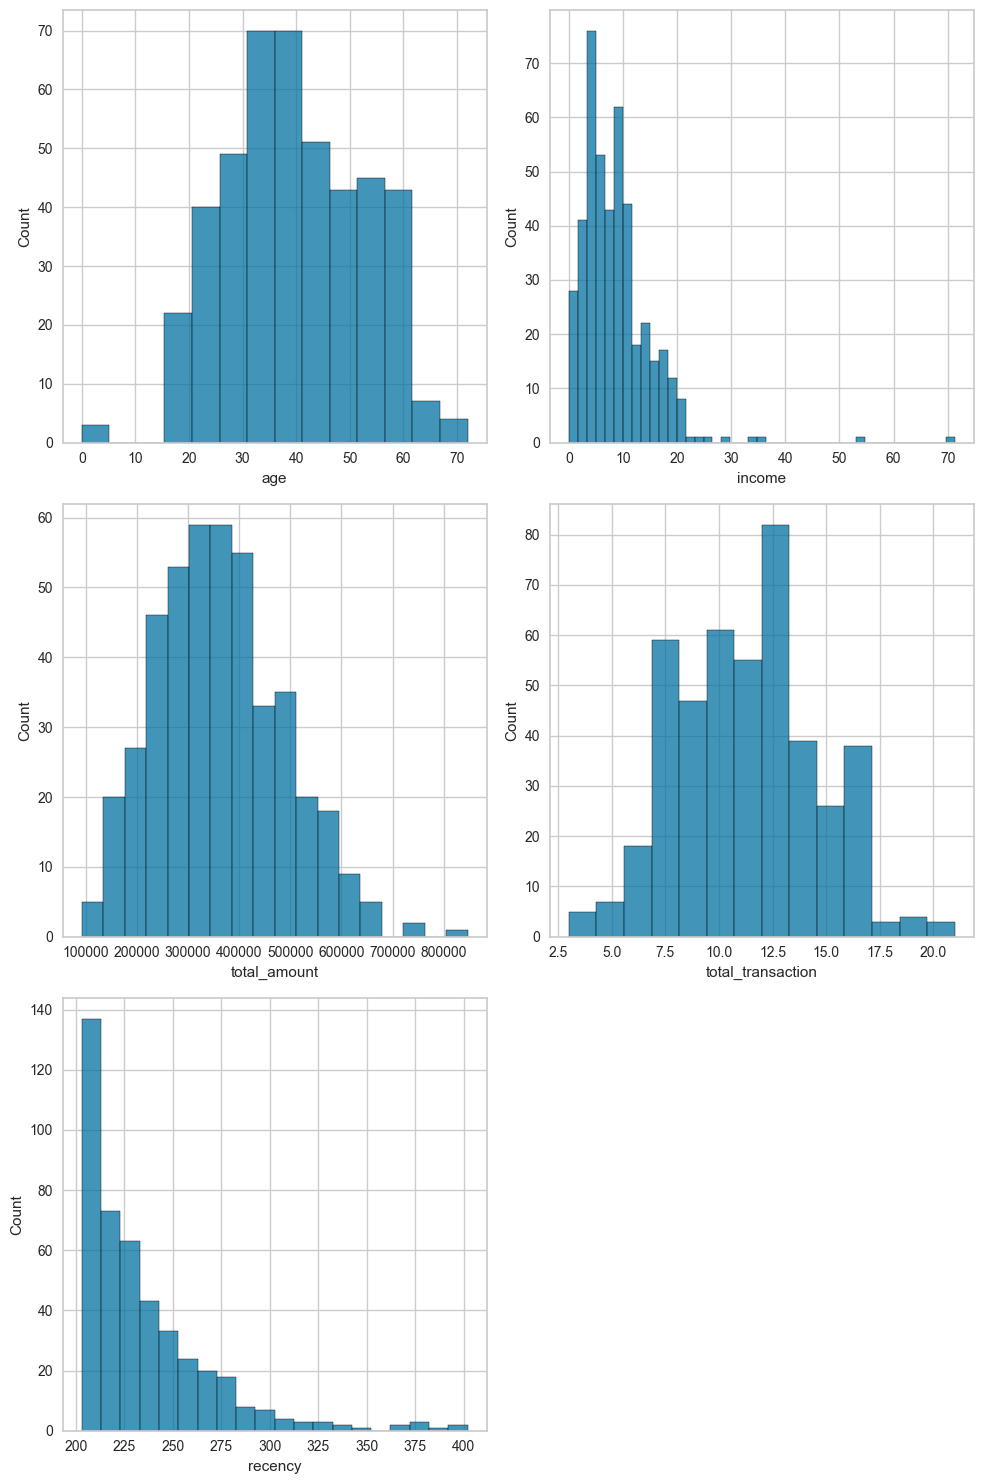

In [7]:
plt.figure(figsize= (10, 15))
for i in range(len(nums)):
    plt.subplot(3, 2, i+1)
    sns.histplot(x = df[nums[i]])
    plt.tight_layout()

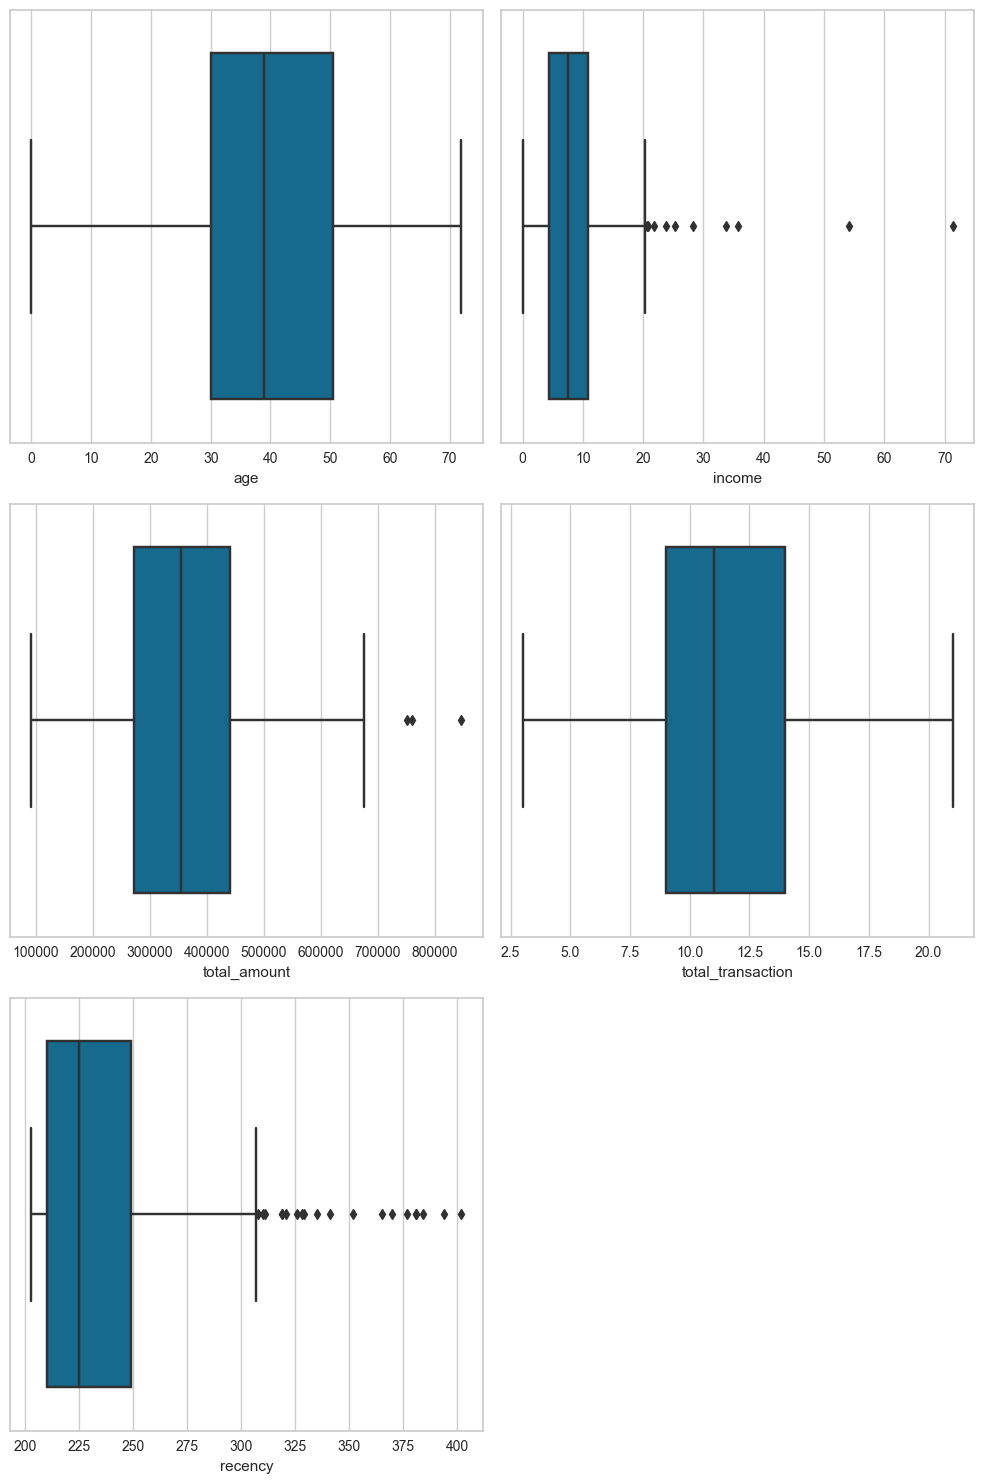

In [8]:
plt.figure(figsize= (10, 15))
for i in range(len(nums)):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x = df[nums[i]])
    plt.tight_layout()

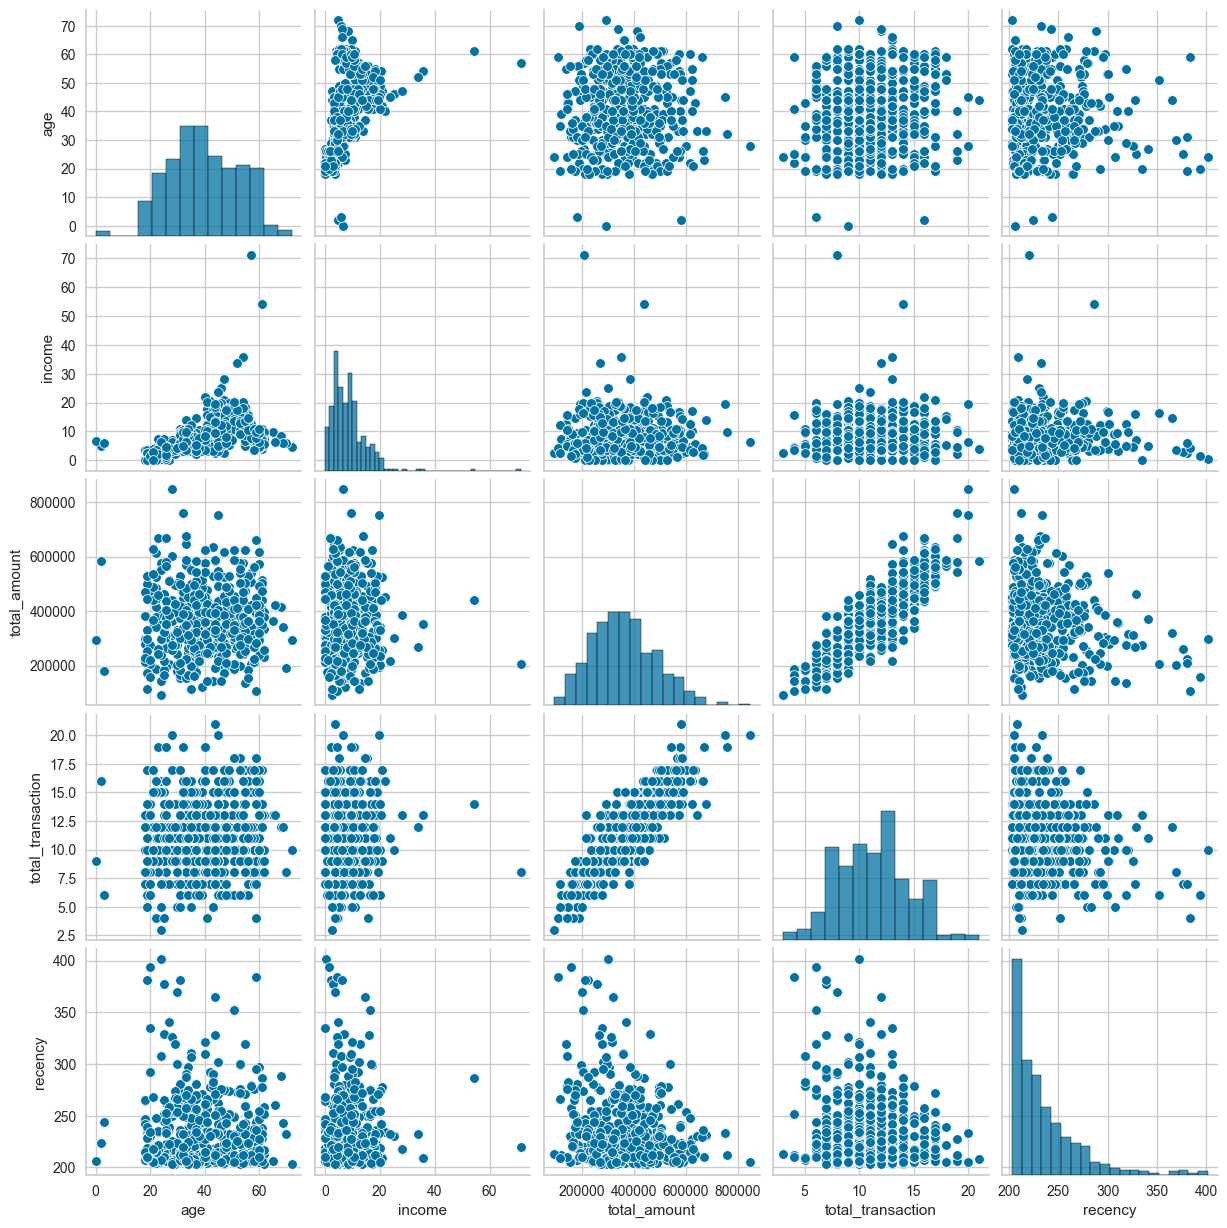

In [9]:
sns.pairplot(df[nums])

### Data Preparation

In this clustering, we will select features that are considered to represent customers well. The RFM framework will be used to define which features are used to represent customers. The RFM framework is a customer segmentation framework that combines multiple factors to categorize customers into distinct groups. Each letter in RFM represents a specific aspect of customer behavior:

* **Recency** measures the number of days that have elapsed since the customer's last purchase, and we will use the 'Recency' column for this.
* **Frequency** indicates the number of transactions that the customer has made, and we will use the 'Total_transaction' column for this.
* **Monetary** is represented by the total amount of money spent by customers. However, in our case, the total_amount and total_transaction features have a very high correlation. If we use both of them, it may potentially cause multicollinearity, which can introduce bias in the model due to redundant features.

    Therefore, we will only use the total_transaction feature because it provides information about the number of interactions performed by customers, giving us insight into their transaction activity. On the other hand, total_spend_amount only gives an overview of how much money customers have spent over a specific period. While this is also important information, total_transaction can offer more valuable insights into customer behavior and purchasing patterns.

    In this case, we will disregard the monetary point, but we will include the income feature to gain a better understanding of how a customer's spending behavior relates to their income level.

In addition to these features, we will also consider additional features:

* **Demographic** segmentation involves categorizing customers based on demographic information, and we will use the 'Age' column for this.

In [10]:
# make a new specified dataset for modeling
df_model = df.drop('total_amount', axis = 1)

Based on the previous data overview, it has been identified that there are extreme outliers in the income and recency columns. To prevent these outliers from biasing the results obtained from further analysis, we will those records of data.

In [11]:
# outlier handling
print('Datasets dimension before outliers handling: ', df_model.shape)
for i in ['income', 'recency']:
    Q1 = df_model[i].quantile(0.25)
    Q3 = df_model[i].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    high = Q3 + 1.5*IQR
    df_model_clean = df_model[(df_model[i] > low) & (df_model[i] < high)]
print('Datasets dimension after outliers handling: ', df_model_clean.shape)

Datasets dimension before outliers handling:  (447, 5)
Datasets dimension after outliers handling:  (427, 5)


In [15]:
# Normalization
minmaxscaler = MinMaxScaler()
df_model_norm = df_model_clean.drop('customerid',axis = 1)
df_model_norm[df_model_norm.columns] = minmaxscaler.fit_transform(df_model_norm[df_model_norm.columns])
df_model_norm

,age,income,total_transaction,recency
0,0.763889,0.071809,0.777778,0.230769
1,0.472222,0.056101,0.611111,0.009615
2,0.625000,0.094109,0.277778,0.028846
3,0.847222,0.760168,0.611111,0.798077
4,0.541667,0.090323,0.666667,0.134615
...,...,...,...,...
442,0.722222,0.244320,0.500000,0.221154
443,0.763889,0.191725,0.500000,0.538462
444,0.708333,0.283590,0.611111,0.019231
445,0.777778,0.203927,0.333333,0.201923


### Modeling

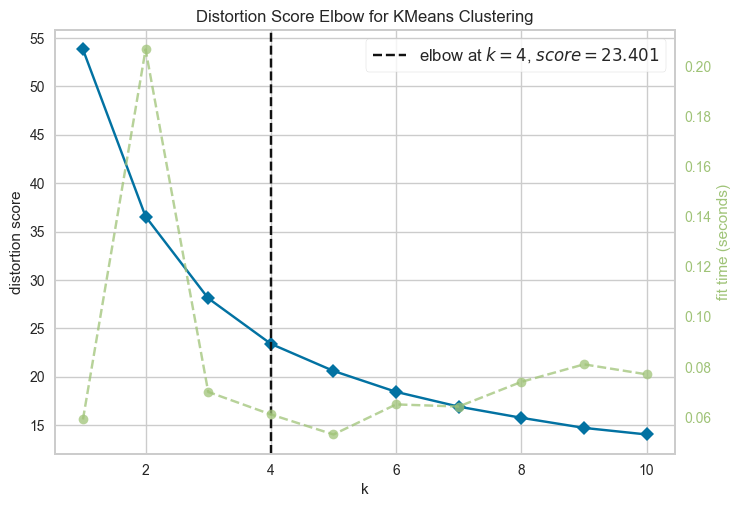

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
#WSS elbow test
WSS =  KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
visualizer = KElbowVisualizer(WSS, k=(1,11))

visualizer.fit(df_model_norm)
visualizer.show()

In [23]:
# Clustering model
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 0)
kmeans.fit(df_model_norm)
df_model_clean['CLUSTER'] = kmeans.labels_
df_model_norm['CLUSTER'] = kmeans.labels_

C:\Users\una\AppData\Local\Temp\ipykernel_5876\3450014071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['CLUSTER'] = kmeans.labels_


In [24]:
silhouette_avg = silhouette_score(df_model_norm, kmeans.labels_)
print(silhouette_avg)

0.7270157342413102


Text(0.5, 1.0, 'Score Silhouette : 0.727')

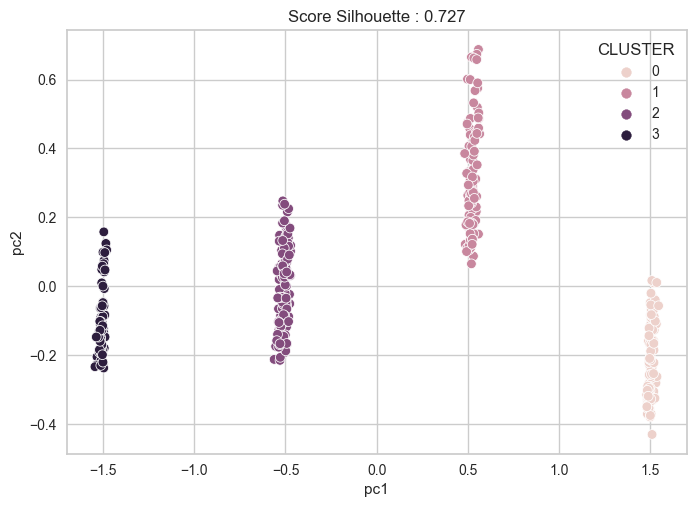

In [25]:
pcs = PCA(n_components = 2).fit_transform(df_model_norm)
pdf = pd.DataFrame(data = pcs, columns = ['pc1', 'pc2'])
pdf['CLUSTER'] = kmeans.labels_
sns.scatterplot(pdf, x = 'pc1', y = 'pc2', hue = 'CLUSTER')
text = 'Score Silhouette : ' + silhouette_avg.round(4).astype(str)
plt.title(text)

### Conclusion

In [30]:
# Overview the obtained ckusters
agg_cluster = df_model_clean.drop('customerid', axis = 1).groupby('CLUSTER').agg('median').round(2)
agg_cluster

,age,income,total_transaction,recency
CLUSTER,,,,
0,31.0,4.74,9.0,216.0
1,40.0,7.72,10.0,265.5
2,52.0,11.31,12.0,218.0
3,30.0,4.52,14.0,213.0
